<a href="https://colab.research.google.com/github/roshanrawatt/DeepLearning-Capstone/blob/main/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 4.8 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
     |████████████████████████████████| 376 kB 44.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=8b8833be0e14366226a785f5fcc8040577babb204d1ec6817b8c7646a64a59e9
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=1ddd7c643d7cfb1d12087057d738679e61d89d7a9d5e5061ff536a351e3ed0ad
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 33.70 MiB/s, done.


In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/' 
CSV_FILE= '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR=0.001
EPOCHS = 15
DEVICE='cuda'

In [ ]:
df = pd.read_csv('/content/Person-Re-Id-Dataset/train.csv')
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row=df.iloc[4]

A_img=io.imread(DATA_DIR + row.Anchor)
N_img=io.imread(DATA_DIR + row.Negative)
P_img=io.imread(DATA_DIR + row.Positive)

In [ ]:
img=io.imread('/content/Person-Re-Id-Dataset/train/1420_c5s3_052165_01.jpg')


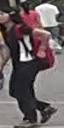

In [ ]:
import plotly.express as px
px.imshow(A_img)

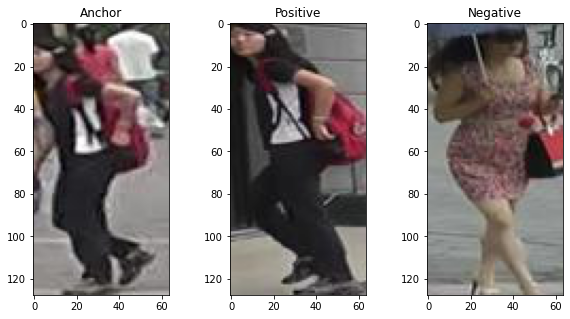

In [ ]:
f, (ax1, ax2, ax3)=plt.subplots(1,3, figsize=(10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [ ]:
df.shape

(4000, 3)

In [ ]:
train_df, valid_df= train_test_split(df, test_size= 0.2, random_state=42)

**Create APN Dataset**

In [ ]:
class APN_DATASET(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    N_img = io.imread(DATA_DIR + row.Negative)
    P_img = io.imread(DATA_DIR + row.Positive)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1)/255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1)/255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1)/255.0

    return A_img, P_img, N_img

In [ ]:
train_set = APN_DATASET(train_df)
valid_set = APN_DATASET(valid_df)

print(f" Size of Train Set : {len(train_set)}")
print(f" Size of Test Set : {len(valid_set)}")

 Size of Train Set : 3200
 Size of Test Set : 800


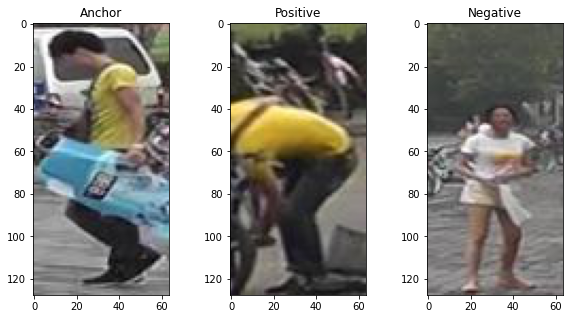

In [ ]:
#Plotting the data

idx = 40

A,P,N = train_set[idx]

f, (ax1, ax2, ax3)= plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1, 2, 0)), cmap='gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1, 2, 0)), cmap='gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1, 2, 0)), cmap='gray')



In [ ]:
#Load dataset into batches
trainloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(valid_set, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
print(f" Number of batches in Train Loader : {len(trainloader)}")
print(f" Number of batches in Valid Loader : {len(validloader)}")

 Number of batches in Train Loader : 100
 Number of batches in Valid Loader : 25


In [ ]:
#Creating Model
class APN_MODEL(nn.Module):

  def __init__(self, emb_size=512):
    super(APN_MODEL, self).__init__()

    self.efficientnet= timm.create_model('efficientnet_b0', pretrained= True)
    self.efficientnet.classifier = nn.Linear(in_features= self.efficientnet.classifier.in_features, out_features = emb_size)
  
  def forward(self, images):


    embeddings = self.efficientnet(images)
    return embeddings
   

In [ ]:
model = APN_MODEL()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


APN_MODEL(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine

IndentationError: ignored

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
  
  model.train()
  total_loss=0.0
  
  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)
    
    loss = criterion(A_embs, P_embs, N_embs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
    
    total_loss += loss.item()
 
  return total_loss/len(dataloader)



In [ ]:
def eval_fn(model, dataloader, criterion):
  
  model.eval()
  total_loss=0.0
 
  for A, P, N in tqdm(dataloader):
   
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)
    
    loss = criterion(A_embs, P_embs, N_embs)

    total_loss += loss.item()
 
  return total_loss/len(dataloader)


In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

**Create Training Loop**

In [ ]:
best_valid_loss= np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED WEIGHTS SUCCESS")

  print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss : {valid_loss}")

100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 1 train_loss: 0.5699644334614277 valid_loss : 0.46189655900001525


100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 2 train_loss: 0.30469599932432173 valid_loss : 0.28570844113826754


100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


EPOCHS: 3 train_loss: 0.16759112790226938 valid_loss : 0.31183933138847353


100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 4 train_loss: 0.13557277172803878 valid_loss : 0.2264024233818054


100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 5 train_loss: 0.09554356843233108 valid_loss : 0.19515518844127655


100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 6 train_loss: 0.04778510190546512 valid_loss : 0.17802364468574525


100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


EPOCHS: 7 train_loss: 0.03840866096317768 valid_loss : 0.18610061466693878


100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 8 train_loss: 0.044172045439481736 valid_loss : 0.1667955482006073


100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 9 train_loss: 0.04631547302007675 valid_loss : 0.1498058968782425


100%|██████████| 25/25 [00:02<00:00, 10.50it/s]


EPOCHS: 10 train_loss: 0.05275441326200962 valid_loss : 0.21382611334323884


100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


EPOCHS: 11 train_loss: 0.06003917381167412 valid_loss : 0.1763979497551918


100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


EPOCHS: 12 train_loss: 0.05047310046851635 valid_loss : 0.18853329062461854


100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


EPOCHS: 13 train_loss: 0.0493784573674202 valid_loss : 0.20218422293663024


100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


EPOCHS: 14 train_loss: 0.036660601794719694 valid_loss : 0.1819191324710846


100%|██████████| 25/25 [00:02<00:00, 10.27it/s]

EPOCHS: 15 train_loss: 0.03436457693576813 valid_loss : 0.19528871178627014


**Get Anchor Embeddings**

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr= np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    
    encodings=np.array(encodings)
    encodings=pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)
  
  return df_enc

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:41<00:00, 96.04it/s]


In [ ]:
# Save the csv file
df_enc.to_csv('database.csv',index = False )


In [ ]:
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.518643,0.429826,-1.221727,-0.408843,0.006560,-0.425596,-0.332832,0.195953,0.422188,...,-0.426629,-0.244530,0.185952,1.056054,0.743490,0.148569,0.508988,0.166072,-1.205595,0.568167
1,1420_c3s3_061978_03.jpg,0.426466,0.037461,-0.706700,-0.244968,0.026164,-0.387452,-0.435698,-0.334340,0.439895,...,-0.594545,-0.433792,-0.047405,0.644267,0.454677,0.065330,0.239555,0.175858,-1.110885,0.617700
2,1420_c5s3_062565_05.jpg,0.141787,0.244994,-0.980230,-0.366904,0.125451,-0.571802,-0.339319,-0.466013,0.414100,...,-0.581813,-0.546386,0.043000,0.907248,0.665018,0.019808,0.565267,0.308063,-1.425097,0.973909
3,1420_c6s3_085592_04.jpg,0.433054,0.419473,-1.166830,-0.302792,0.090208,-0.415492,-0.324110,0.322652,0.535499,...,-0.259138,-0.086236,0.248293,1.145558,0.634353,-0.013606,0.729830,0.123608,-1.053474,0.635413
4,0663_c5s3_085987_03.jpg,-0.363307,0.959807,-1.167522,-0.206812,-0.912737,-0.294246,-0.027687,1.253513,0.107032,...,-0.060910,0.477434,1.286515,-0.201804,-1.063143,-0.449083,0.084485,0.647135,-0.718231,0.094725
